# CogPonder: A Model-Agnostic Approach to Response Times in Cognitive Tasks

Of our interest is a simultaneous model of speed and accuracy of human responses.

Inspired by [PonderNet](https://arxiv.org/abs/2107.05407), this notebook demonstrate a interoperable model that produces human-like speed-accuracy in decision making tasks.

The model iterates over a recurrent decision network, terminating only when it reaches a halting step. The network is trained to maximize accuracy and minimize the difference between the human response time and the halting step of the network.


## Tasks

### 2-back Task

The subject is presented with a sequence of letters, and are asked to respond with "target" button whe the current stimulus matches the one from n steps earlier in the sequence. The load factor n can be adjusted to make the task more or less difficult.

We use a mock 2-back dataset to evaluate the architecture. The mock dataset includes trial-level $X$, $responses$, $targets$, and $response\_times$ for each subject.


### Decision Model

We want to learn a supervised approximation of the $X \to y$ as follows:

$
f: X,h_n \mapsto \tilde{y},h_{n+1}, \lambda_n
$

where $X$ and $y$ denote recent stimulus and responses, $\lambda_n$ is the halting probability at step $n$, and $h_{n}$ is the latent state of the decision model. The learning process continues for a maximum of $N_{max}$ steps. For brevity, each time step is considered 100ms. ($\lambda_n$) is the halting probability in step $n$ (given a Bernoulli distribution).

In case of the 2-back task, X is a moving window of recent 2 stimuli symbols, e.g., A, B, C, D, ...; and $y$ is either MATCH or NON_MATCH.

### Output

The *PonderNet* model produces $y\_steps$, $p\_halts$, $halt\_steps$ for each item in the batch. Batch items are the trials in the 2-back task.


### Criterion

$L = L_{rec} + L_{reg_{RT}}$


In [1]:
%reload_ext autoreload
%autoreload 3

import torch
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from cogponder import NBackDataset, PonderNet, ICOM, evaluate

## Data

In [2]:


# generate mock n-back data

N_STIMULI = 6

dataset = NBackDataset(n_subjects=2, n_trials=100, n_stimuli=N_STIMULI)

X, targets, responses, response_steps = dataset[0]
dataset = TensorDataset(X, targets.float(), responses, response_steps)

In [3]:
# evaluate the model

N_EPOCHS = 1000
MAX_STEPS = response_steps.detach().max() + 10
N_OUTPUTS = torch.unique(targets).size()[0]
LAMBDA_P = 1 / response_steps.detach().float().median()

model = PonderNet(ICOM, N_STIMULI+1, N_STIMULI, N_OUTPUTS, MAX_STEPS)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# ====== DEBUG ========
# model.train()
# y_pred, p_halts, halt_steps = model(X)
# from cogponder import RegularizationLoss
# loss_func = RegularizationLoss(LAMBDA_P, MAX_STEPS)
# loss_func(p_halts, halt_steps, responses, response_steps)
# =====================

results = evaluate(model, dataset, optimizer,
                   n_epochs=N_EPOCHS,
                   lambda_p=LAMBDA_P,
                   batch_size=4,
                   loss_beta=.5,
                   max_steps=MAX_STEPS)

model, X_train, X_test, y_train, y_test, r_train, r_test, rt_train, rt_test = results


Epochs: 100%|██████████| 1000/1000 [00:36<00:00, 27.53it/s]


In [4]:
# DEBUG

with torch.no_grad():
    model.eval()
    rt_train_pred = model(X_train)[2].detach()
    rt_test_pred = model(X_test)[2].detach()

    # DEBUG report the ground truth and predicted response times
    print('TRUE TRAIN:', rt_train.detach().tolist(), '\nPRED TRAIN:',  rt_train_pred.tolist())
    print('TRUE TEST:', rt_test.detach().tolist(), '\nPRED TEST:',  rt_test_pred.tolist())

# DEBUG report medians
# rt_train_pred.median(), rt_train.float().median()
# rt_test_pred.median(), rt_test.float().median()

TRUE TRAIN: [3, 3, 3, 2, 5, 7, 2, 4, 3, 2, 4, 2, 3, 2, 3, 9, 7, 2, 4, 3, 5, 7, 4, 2, 2, 8, 2, 3, 2, 3, 2, 2, 7, 4, 3, 2, 4, 2, 2, 2, 5, 2, 2, 2, 3, 7, 5, 2, 3, 2, 2, 7, 2, 2, 2, 10, 4, 7, 4, 2, 2, 4, 7, 2, 3, 2, 11, 3, 11, 2, 2, 4, 3, 2, 3, 4, 2, 6] 
PRED TRAIN: [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
TRUE TEST: [3, 2, 3, 2, 2, 3, 2, 3, 5, 2, 2, 2, 8, 3, 4, 3, 2, 2, 4, 5] 
PRED TEST: [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]


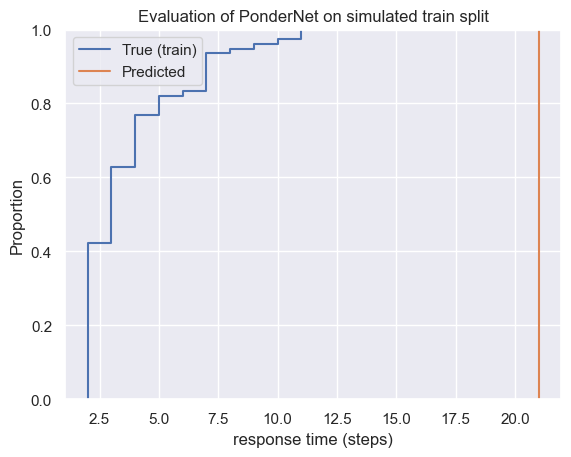

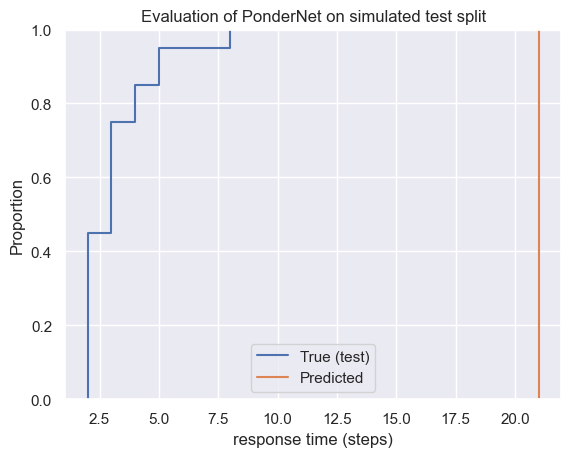

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.ecdfplot(rt_train.detach(), label='True (train)')
sns.ecdfplot(rt_train_pred.detach(), label='Predicted')

plt.title('Evaluation of PonderNet on simulated train split')
plt.xlabel('response time (steps)')

plt.legend()
plt.show()

sns.ecdfplot(rt_test.detach(), label='True (test)')
sns.ecdfplot(rt_test_pred.detach(), label='Predicted')

plt.title('Evaluation of PonderNet on simulated test split')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()

/usr/local/Caskroom/miniforge/base/envs/ponder/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/Caskroom/miniforge/base/envs/ponder/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


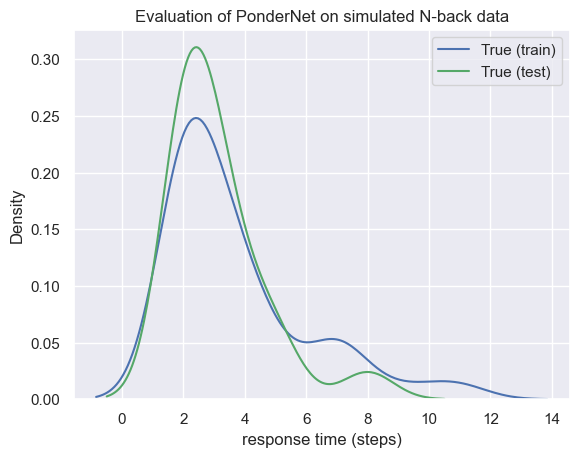

In [6]:

sns.kdeplot(rt_train.detach(), label='True (train)')
sns.kdeplot(rt_train_pred.detach(), label='Predicted')

sns.kdeplot(rt_test.detach(), label='True (test)')
sns.kdeplot(rt_test_pred.detach(), label='Predicted')


plt.title('Evaluation of PonderNet on simulated N-back data')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()